## Clustering for Structural Vulnerability Interpretation

To further interpret the multidimensional structure of financial vulnerability, **K-means clustering** is applied to the factor scores as an exploratory analytical step. While the RFVI ranks regions by overall vulnerability, clustering groups observations based on *how that vulnerability is formed*.

The analysis operates at two geographic perspectives:

**Regional level (primary analytical unit)**

- Monthly survey data are aggregated into **regional mean Sensitivity, Exposure, and Resilience scores**
- Clustering is performed only at this level
- RFVI values and rankings remain unchanged

**Urban-Rural level (interpretive extension)**

- For months where geographic identifiers are available, urban and rural subgroups are extracted
- These inherit the regional cluster classification
- Used for visualization and comparative interpretation, not for redefining clusters

#### Purpose of Clustering

Clustering does not replace the RFVI. Instead, it explains *why regions have similar RFVI values but for different structural reasons.*

It allows identification of patterns such as:
- Sensitivity-driven vulnerability
- Exposure-driven vulnerability
- Resilience-supported conditions
- Mixed or compounded structural risks

Thus:
- **RFVI - measures magnitude of vulnerability**
- **Clusters - explain mechanism of vulnerability**

#### Analytical Workflow Overview

The notebook performs the following stages:

**1) Reconstruction & Preparation**

  - Combine monthly regional factor scores into a longitudinal master dataset
  - Standardize variables to ensure comparable distance measurement

**2) Cluster Validation**

  - Evaluate candidate numbers of clusters (K)
  - Use elbow and silhouette diagnostics

**3) Final Clustering**

  - Apply K-means on standardized dimensions
  - Produce structural vulnerability typologies

**4) Cluster Interpretation**

  - Compute mean profiles per cluster
  - Examine regional membership persistence
  - Visualize separation and structural patterns

**5) Dataset Integration**

  - Attach cluster labels
  - Extend classification to urban-rural subsets (when available)

#### Outputs Produced

**Regional Structural Typology Dataset:**
`Regional_Vulnerability_Profiles.csv`

Columns:
- Region, year, and month
- Sensitivity, Exposure, Resilience (normalized & standardized)
- Cluster number and descriptive label
- RFVI value

**Urban-Rural Structural Typology Dataset**
`Urban_Rural_Vulnerability_Profiles.csv`

- Same columns, disaggregated by Urban/Rural (available months only)
- Uses regional cluster assignment for interpretation

---
### Data Reconstruction & Standardization

Clustering requires consistent observations across time, so a single longitudinal regional dataset is reconstructed.

- Monthly survey files are aggregated into **regional mean factor scores**
- A placeholder geographic identifier (Urban_RuralFIES = "Regional Total") is attached to preserve compatibility with later urban-rural aggregation
- All months are combined into one master longitudinal dataset and saved

To ensure fair distance calculations during clustering:
- Sensitivity, Resilience, and Exposure are standardized using Z-scores
- These standardized variables become the clustering inputs

This step produces a consistent, scale-balanced dataset representing regional vulnerability conditions across time, ready for clustering analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import gc
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# --- SETUP & CONFIGURATION ---
try:
    with open(Path("./data/interim/config.json")) as f:
        cfg = json.load(f)
    BASE_PATH = Path(cfg["BASE_PATH"])
    ENRICHED_SOURCE = BASE_PATH / "FINAL Survey Datasets with Factor Scores and RFVI"
    
    LONG_MASTER_FILE = Path("./data/processed/regional_longitudinal_master.csv")
    print(f" Configuration Loaded. Free space: 0.59 GB. Using Ultra-Lean mode.")
except Exception as e:
    print(f" Error loading config: {e}")

# --- DATA RECONSTRUCTION (ULTRA-LEAN) ---
if ENRICHED_SOURCE.exists():
    all_files = list(ENRICHED_SOURCE.rglob("Enriched_*.csv"))
    all_cp_data = []

    for i, f in enumerate(all_files):
        # PROCESS STEP: Only read 5 specific columns to keep usage minimal
        target_cols = ['Region', 'Sensitivity_Score_norm', 'Resilience_Score_norm', 'Exposure_Score_norm', 'RFVI']
        
        # We use usecols here to avoid loading the whole 50MB+ file into RAM
        temp_raw = pd.read_csv(f, usecols=target_cols)
        
        # Aggregate immediately
        m_df = temp_raw.groupby('Region').mean().reset_index()
        m_df['Urban_RuralFIES'] = "Regional Total"
        
        # Metadata
        parts = f.parent.name.split('_')
        m_df['Survey_Year'] = parts[0]
        m_df['Survey_Month'] = parts[1]
        
        all_cp_data.append(m_df)
        
        del temp_raw
        gc.collect() 
        
        print(f"   Progress: {i+1}/{len(all_files)} | {f.parent.name}".ljust(60), end="\r")

    # Combine into master
    df_master = pd.concat(all_cp_data).reset_index(drop=True)
    
    # Save master (index=False saves space)
    df_master.to_csv(LONG_MASTER_FILE, index=False)
    print(f"\n Master saved successfully: {LONG_MASTER_FILE}")
else:
    print(" CRITICAL ERROR: ENRICHED_SOURCE folder not found.")

# --- STANDARDIZATION ---
features = ['Sensitivity_Score_norm', 'Resilience_Score_norm', 'Exposure_Score_norm']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_master[features])

std_cols = ['S_std', 'R_std', 'E_std']
df_master[std_cols] = X_scaled

print(f"\n Dataset Prepared: {df_master.shape[0]} observations.")
display(df_master.head())

 Configuration Loaded. Free space: 0.59 GB. Using Ultra-Lean mode.
   Progress: 37/37 | 2024_March                             
 Master saved successfully: data\processed\regional_longitudinal_master.csv

 Dataset Prepared: 629 observations.


,Region,Sensitivity_Score_norm,Resilience_Score_norm,Exposure_Score_norm,RFVI,Urban_RuralFIES,Survey_Year,Survey_Month,S_std,R_std,E_std
0,Autonomous Region in Muslim Mindanao (ARMM),0.440029,0.291736,0.263922,0.470739,Regional Total,2018,April,2.589608,-2.037100,-1.009026
1,Cordillera Administrative Region (CAR),0.409992,0.315651,0.274179,0.456173,Regional Total,2018,April,0.319925,-0.450875,-0.200783
2,National Capital Region (NCR),0.411341,0.321898,0.268459,0.452634,Regional Total,2018,April,0.421828,-0.036483,-0.651473
3,Region I (Ilocos Region),0.420786,0.329835,0.279348,0.456766,Regional Total,2018,April,1.135547,0.489960,0.206609
4,Region II (Cagayan Valley),0.416971,0.325865,0.284101,0.458403,Regional Total,2018,April,0.847306,0.226596,0.581161


---
### Cluster Diagnostics & Selection

Before assigning clusters, diagnostic tests are performed to determine the appropriate number of structural vulnerability types.

Multiple K-means simulations are run using different numbers of groups (k):
- **Elbow Method** - checks how compact the groups become
- **Silhouette Score** - checks how separated the groups are

The diagnostic plots:
- Identify the point where improvement stops increasing meaningfully
- Provide statistical evidence for selecting the final number of groups

This prevents random grouping, ensures clusters represent meaningful structural differences, and establishes empirical justification for the chosen number of vulnerability types.

 Running K-Means simulations to find optimal vulnerability types...
K     | Inertia (Elbow)    | Silhouette Score  
---------------------------------------------
2     | 1337.32            | 0.2813            
3     | 1086.70            | 0.3046            
4     | 855.65             | 0.3150            
5     | 713.34             | 0.2591            
6     | 619.49             | 0.2592            
7     | 538.09             | 0.2769            
8     | 473.69             | 0.2764            
9     | 430.31             | 0.2694            


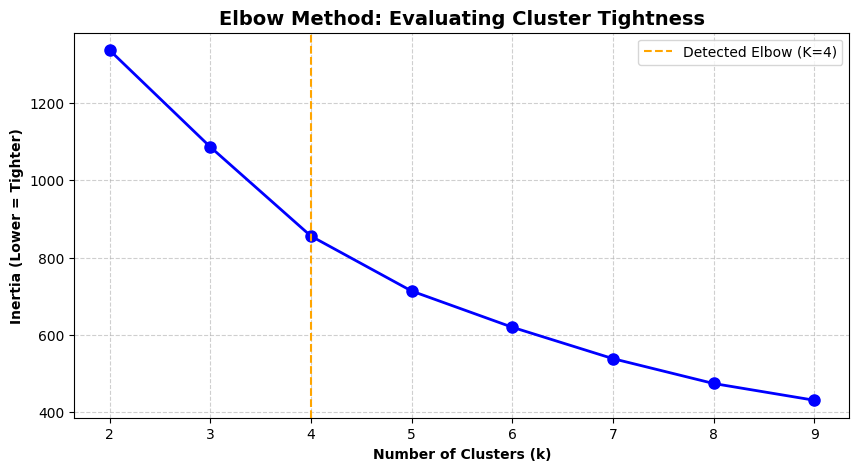

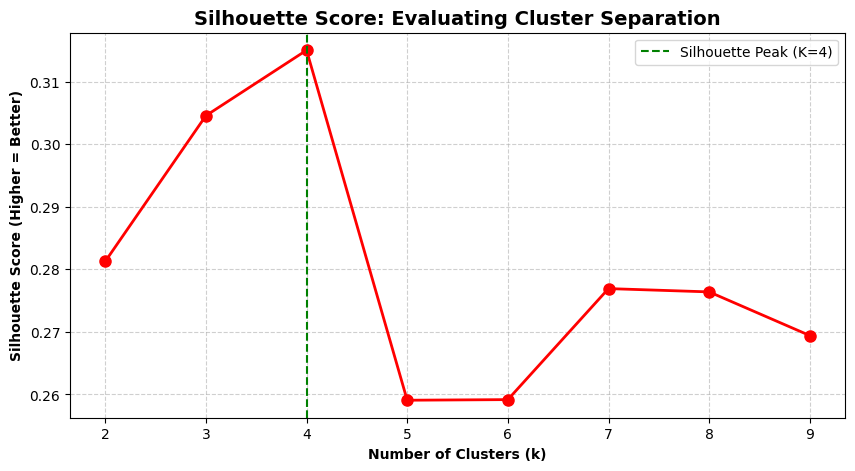

---------------------------------------------
 DIAGNOSTIC COMPLETE
 Elbow Method Recommendation: K = 4
 Silhouette Score Recommendation: K = 4


In [2]:
# --- CLUSTERING DIAGNOSTICS: SIMULATION & VISUALIZATION ---
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Preparation: Using the standardized columns for the distance math
X_input = df_master[['S_std', 'R_std', 'E_std']]

inertia = []
silhouette_avg = []
k_range = range(2, 10) 

print(" Running K-Means simulations to find optimal vulnerability types...")
print(f"{'K':<5} | {'Inertia (Elbow)':<18} | {'Silhouette Score':<18}")
print("-" * 45)

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_input)
    
    # Calculate Metrics
    current_inertia = kmeans.inertia_
    current_silhouette = silhouette_score(X_input, cluster_labels)
    
    inertia.append(current_inertia)
    silhouette_avg.append(current_silhouette)
    
    # Print values for each K as requested
    print(f"{k:<5} | {current_inertia:<18.2f} | {current_silhouette:<18.4f}")

# --- CALCULATING RECOMMENDATIONS ---

# 1. Silhouette Recommendation (Mathematical Peak)
optimal_k_sil = k_range[np.argmax(silhouette_avg)]

# 2. Elbow Recommendation
# We look for the point where the change in slope decreases most sharply
diffs = np.diff(inertia)
diffs_ratios = diffs[:-1] / diffs[1:]
optimal_k_elbow = k_range[np.argmax(diffs_ratios)] + 1

# --- VISUALIZATION ---

# CHART 1: ELBOW METHOD
plt.figure(figsize=(10, 5))
plt.plot(k_range, inertia, 'bo-', linewidth=2, markersize=8)
plt.axvline(x=optimal_k_elbow, color='orange', linestyle='--', label=f'Detected Elbow (K={optimal_k_elbow})')
plt.title('Elbow Method: Evaluating Cluster Tightness', fontsize=14, fontweight='bold')
plt.xlabel('Number of Clusters (k)', fontweight='semibold')
plt.ylabel('Inertia (Lower = Tighter)', fontweight='semibold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# CHART 2: SILHOUETTE SCORE
plt.figure(figsize=(10, 5))
plt.plot(k_range, silhouette_avg, 'ro-', linewidth=2, markersize=8)
plt.axvline(x=optimal_k_sil, color='green', linestyle='--', label=f'Silhouette Peak (K={optimal_k_sil})')
plt.title('Silhouette Score: Evaluating Cluster Separation', fontsize=14, fontweight='bold')
plt.xlabel('Number of Clusters (k)', fontweight='semibold')
plt.ylabel('Silhouette Score (Higher = Better)', fontweight='semibold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("-" * 45)
print(f" DIAGNOSTIC COMPLETE")
print(f" Elbow Method Recommendation: K = {optimal_k_elbow}")
print(f" Silhouette Score Recommendation: K = {optimal_k_sil}")

#### Cluster Diagnostics Interpretation (Elbow & Silhouette)

To determine the optimal number of vulnerability groups, K-means clustering is evaluated using both the **Elbow Method (Inertia)** and the **Silhouette Score**.

**1) Elbow Method (Cluster Tightness)**

- Inertia steadily decreases as K increases.
- The most visible bend occurs at K = 4:
  - K=2 → 1337.32
  - K=3 → 1086.70
  - **K=4 → 855.65**
  - K=5 → 713.34 (smaller marginal improvement)

Interpretation:

- There is a large reduction in inertia up to K=4.
- After K=4, improvements become noticeably smaller.
- This indicates diminishing returns when adding more clusters.
- **Chart context:** On the elbow plot, the “bend” at K=4 is the point where the curve starts to flatten, visually signaling that adding more clusters yields little extra benefit.

Therefore, four groups sufficiently capture the major structural patterns in the data without unnecessary complexity.

**2) Silhouette Score (Cluster Separation)**

Silhouette score improves from K=2 to K=4 and then declines:
- K=2 → 0.2813
- K=3 → 0.3046
- **K=4 → 0.3150 (peak)**
- K=5 → 0.2591
- K=6 → 0.2592
- K=7-9 remain lower than K=4

Interpretation:

- The peak silhouette value occurs at K=4. This means:
  - Strongest separation between clusters
  - Better internal cohesion within clusters
  - Higher K values reduce separation quality.
- **Chart context:** On the silhouette plot, the highest point at K=4 indicates clusters are well-defined and distinct. Lower values beyond K=4 show clusters start overlapping or become less meaningful.

Thus, K=4 maximizes structural distinctiveness.

**Combined Diagnostic Conclusion**

- Both diagnostics independently recommend K = 4.
- Both charts visually confirm the bend and peak at K=4.

The elbow plot shows where adding clusters stops giving major benefits, and the silhouette plot shows where clusters are most separated. This alignment strengthens confidence in selecting **four vulnerability typologies.**

---
### Cluster Execution & Typology Profiling

After selecting the optimal K, the final clustering model is executed and regions are assigned to structural vulnerability profiles.

The results are then interpreted through:

- **Cluster profiles:** Average Sensitivity, Exposure, Resilience, and RFVI within each group

→ explains *why* vulnerability occurs

- **Regional membership frequency:** How often each region belongs to each group across months

→ shows persistent structural characteristics

This step converts numerical factor scores into an interpretable **vulnerability typology** while keeping the RFVI ranking unchanged.

In [3]:
# --- FINAL CLUSTER EXECUTION (K=4) ---
FINAL_K = 4

# Fit the final model using the standardized inputs
kmeans_final = KMeans(n_clusters=FINAL_K, init='k-means++', random_state=42, n_init=10)
df_master['Vulnerability_Cluster'] = kmeans_final.fit_predict(X_input)

# --- CLUSTER PROFILING ---
# We use the original normalized scores for the table so the numbers are easy to read (0 to 1)
profile_cols = ['Sensitivity_Score_norm', 'Resilience_Score_norm', 'Exposure_Score_norm', 'RFVI']

# Calculate the mean for each cluster and sort by RFVI (lowest to highest vulnerability)
cluster_profiles = df_master.groupby('Vulnerability_Cluster')[profile_cols].mean().sort_values(by='RFVI')

print(" VULNERABILITY TYPOLOGY PROFILES (Mean Scores per Cluster):")
print("-" * 75)
display(cluster_profiles.round(4))

# --- MEMBERSHIP ANALYSIS ---
# How many times does each region appear in each cluster?
membership = pd.crosstab(df_master['Region'], df_master['Vulnerability_Cluster'])
print("\n CLUSTER MEMBERSHIP BY REGION (Frequency over 37 months):")
display(membership)

# Save the final clustered dataset
OUTPUT_FILE = Path("./data/processed/rfvi_longitudinal_clustered_master.csv")
df_master.to_csv(OUTPUT_FILE, index=False)
print(f"\n Categorized dataset saved to: {OUTPUT_FILE}")

 VULNERABILITY TYPOLOGY PROFILES (Mean Scores per Cluster):
---------------------------------------------------------------------------


,Sensitivity_Score_norm,Resilience_Score_norm,Exposure_Score_norm,RFVI
Vulnerability_Cluster,,,,
3,0.4126,0.3743,0.2856,0.4413
0,0.3957,0.3203,0.2696,0.4483
2,0.4169,0.3223,0.2784,0.4576
1,0.4078,0.3136,0.3055,0.4665



 CLUSTER MEMBERSHIP BY REGION (Frequency over 37 months):


Vulnerability_Cluster,0,1,2,3
Region,,,,
Autonomous Region in Muslim Mindanao (ARMM),1,16,19,1
Cordillera Administrative Region (CAR),30,1,5,1
National Capital Region (NCR),33,1,2,1
Region I (Ilocos Region),24,1,10,2
Region II (Cagayan Valley),23,1,10,3
Region III (Central Luzon),27,1,8,1
Region IV-A (CALABARZON),22,1,13,1
Region IV-B (MIMAROPA),8,1,27,1
Region IX (Zamboanga Peninsula),17,3,16,1



 Categorized dataset saved to: data\processed\rfvi_longitudinal_clustered_master.csv


#### Final Cluster Profiles and Membership Interpretation

**1) Vulnerability Typology Profiles (Cluster Means)**

| Cluster | Label | Sensitivity | Resilience | Exposure | RFVI | Interpretation |
|---------|--------|-------------|------------|----------|------|----------------|
| **3** | **Resilience-Supported Group** | 0.4126 (moderate) | **0.3743 (highest)** | 0.2856 (lower) | **0.4413 (lowest)** | Shows the strongest coping capacity among clusters. Moderate sensitivity combined with lower exposure and comparatively higher resilience corresponds to the lowest overall vulnerability. |
| **0** | **Sensitivity–Exposure Contained Group** | **0.3957 (lowest)** | 0.3203 (moderate) | **0.2696 (lowest)** | 0.4483 | Characterized by lower sensitivity and the lowest exposure, with moderate resilience. Vulnerability is moderate, reflecting limited risk exposure rather than resilience-driven mitigation. |
| **2** | **Sensitivity-Centered Group** | **0.4169 (highest)** | 0.3223 (moderate-low) | 0.2784 (moderate) | 0.4576 | Defined by the highest sensitivity. Moderate exposure and resilience contribute to relatively elevated vulnerability, indicating structural sensitivity is the dominant factor. |
| **1** | **Exposure–Resilience Strained Group** | 0.4078 (moderate-high) | **0.3136 (lowest)** | **0.3055 (highest)** | **0.4665 (highest)** | Combines the highest exposure with the lowest resilience. Together with moderate-high sensitivity, this cluster shows the highest vulnerability, reflecting compounded risk from external pressures and limited coping capacity. |


**2) Cluster Membership by Region (37 Months)**

**Cluster 0 – Sensitivity-Exposure Contained Group**

Mostly found in NCR, CAR, Central Luzon, CALABARZON, Ilocos, Cagayan Valley, and most Visayas regions.

→ These regions experience lower exposure and moderate resilience.

**Cluster 2 – Sensitivity-Centered Group**

The most common cluster, seen in MIMAROPA, Bicol, Eastern Visayas, SOCCSKSARGEN, Caraga, and parts of Mindanao.

→ These regions are more affected by their sensitivity to shocks. Even with moderate exposure and resilience, sensitivity amplifies the impact of shocks.

**Cluster 1 – Exposure-Resilience Strained Group**

Found mainly in ARMM, SOCCSKSARGEN, Caraga, and parts of Northern Mindanao.

→ These regions face high vulnerability as they are frequently exposed to shocks and have limited coping capacity. Risk is high due to both frequent shocks and weaker resilience.

**Cluster 3 – Resilience-Supported Group**

Seen only in a few regions at certain times.

→ These areas have stronger coping ability. Vulnerability is lower because resilience helps reduce the impact of exposure and sensitivity.

**Overall Interpretation**

The clustering reveals that labor vulnerability is multidimensional rather than one-dimensional. Each cluster reflects a distinct configuration of sensitivity, exposure, and resilience:

| Vulnerability Source        | Represented Cluster |
|----------------------------|---------------------|
| Strong coping capacity     | Cluster 3           |
| Lower exposure and sensitivity        | Cluster 0           |
| Structural sensitivity emphasis   | Cluster 2           |
| Compounded high risk  (high exposure, weak resilience)     | Cluster 1           |

Although the numerical differences across clusters are relatively small, the typology highlights meaningful variations in how vulnerability is structured. Regions with similar RFVI values may belong to different vulnerability configurations, indicating that comparable index scores can arise from different combinations of sensitivity, exposure, and resilience.

---
### Cluster Visualization & Interpretation

After generating clusters, visual diagnostics are performed to interpret and validate their structure.

Two complementary visual diagnostics are created:

**1) Cluster Profile Bar Chart**

- Shows the average Sensitivity, Exposure, and Resilience inside each group
- Makes the drivers of vulnerability immediately visible

This shows the distribution of the vulnerability dimensions in each cluster.

**2) Pair Plot (Separation Check)**

- Displays how observations spread across dimensions
- Visualizes separation between clusters in multidimensional space
- Shows density distributions and overlap
- Evaluates whether groups actually form distinct patterns

This ensures the typology represents real structure rather than random partitioning.

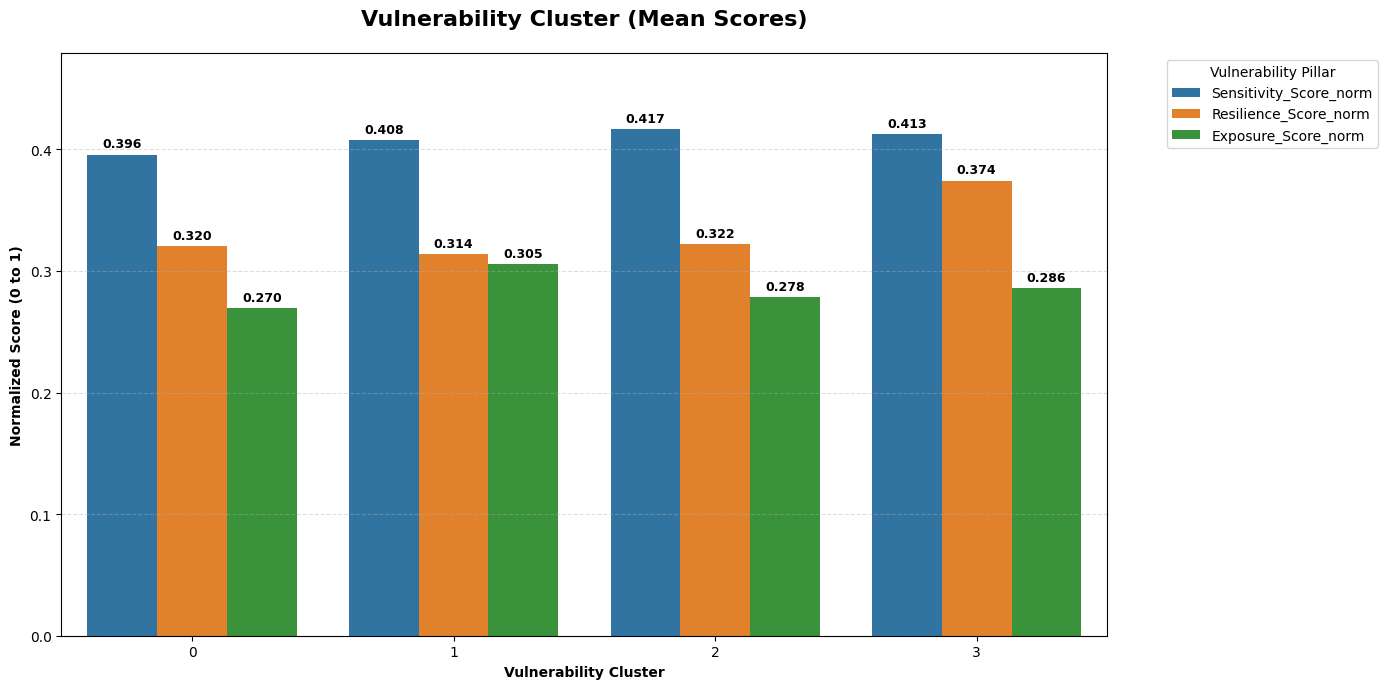

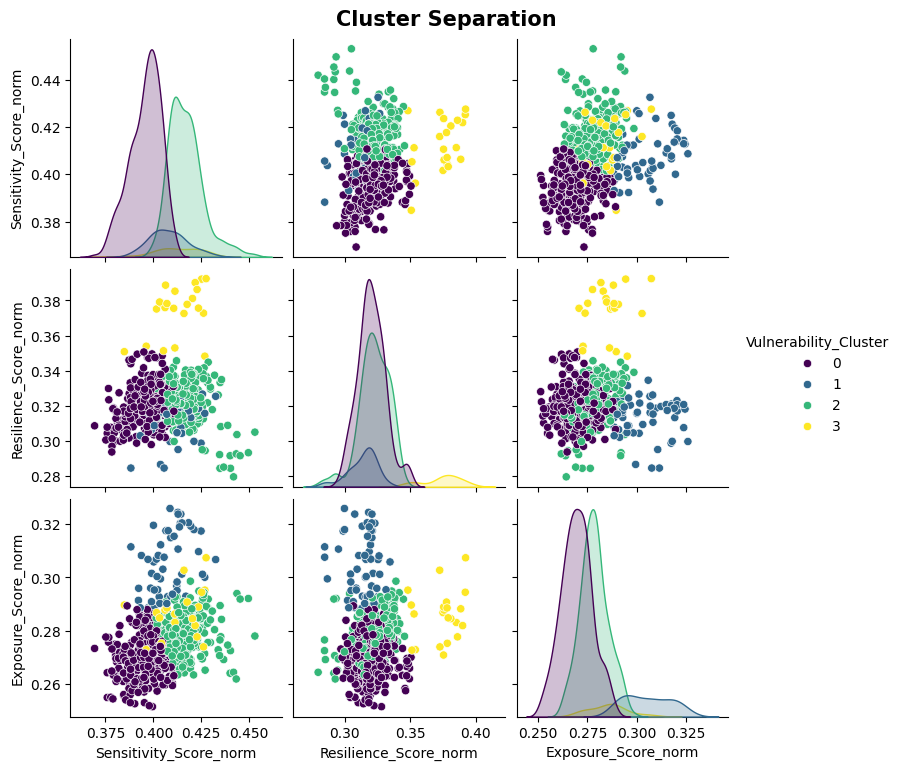

In [4]:
# --- VISUALIZATION OF CLUSTERS WITH VALUE LABELS ---
import seaborn as sns

# A. Cluster Profile Bar Chart
cluster_means_melted = cluster_profiles.reset_index().melt(
    id_vars='Vulnerability_Cluster', 
    value_vars=features
)

plt.figure(figsize=(14, 7))
ax = sns.barplot(data=cluster_means_melted, x='Vulnerability_Cluster', y='value', hue='variable')

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontsize=9, fontweight='bold')

plt.title('Vulnerability Cluster (Mean Scores)', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Normalized Score (0 to 1)', fontweight='bold')
plt.xlabel('Vulnerability Cluster', fontweight='bold')
plt.ylim(0, max(cluster_means_melted['value']) * 1.15) # Add space at the top for labels
plt.legend(title='Vulnerability Pillar', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

# B. Pair Plot 
# Diagnostic view to see how well the groups are actually separated
sns.pairplot(df_master, vars=features, hue='Vulnerability_Cluster', palette='viridis', diag_kind='kde')
plt.suptitle('Cluster Separation', y=1.02, fontsize=15, fontweight='bold')
plt.show()

#### Grouped Bar Chart Interpretation: Mean Dimension Scores

Across all clusters:
- **Sensitivity is highest**
- **Resilience is second**
- **Exposure is lowest**

**Implication:**  
Vulnerability differences are driven more by **structural sensitivity and coping capacity** than by exposure alone.

##### **Cluster 3 – Resilience-Supported Group**
- Sensitivity: 0.4126  
- **Resilience: 0.3743 (highest)**  
- Exposure: 0.2856  

**Interpretation:**  
Higher resilience helps balance moderate sensitivity. Exposure remains relatively contained.


##### **Cluster 0 – Sensitivity–Exposure Contained Group**
- **Sensitivity: 0.3957 (lowest)**  
- Resilience: 0.3203  
- **Exposure: 0.2696 (lowest)**  

**Interpretation:**  
Lower internal fragility and lowest exposure. Profile appears structurally contained rather than resilience-driven.


##### **Cluster 2 – Sensitivity-Centered Group**
- **Sensitivity: 0.4169 (highest)**  
- Resilience: 0.3223  
- Exposure: 0.2784  

**Interpretation:**  
Elevated sensitivity defines this group. Moderate resilience does not fully offset structural susceptibility.


##### **Cluster 1 – Exposure-Resilience Strained Group**
- Sensitivity: 0.4078  
- **Resilience: 0.3136 (lowest)**  
- **Exposure: 0.3055 (highest)**  

**Interpretation:**  
Higher external pressure combined with weaker coping capacity.

#### Key Insight

Clusters are not separated by extreme values in one pillar, but by **how sensitivity, exposure, and resilience combine structurally**.

---
#### Pairplot Interpretation: Multidimensional Cluster Separation

The pairplot visualizes how the four vulnerability clusters are distributed across the three RFVI pillars: **Sensitivity,** **Resilience,** and **Exposure**

- **Diagonal (KDE plots):** Show the distribution of each cluster along one pillar.
- **Off-diagonal (scatter plots):** Show how clusters relate in two-dimensional space.
- Separation along an axis indicates that a pillar helps distinguish clusters.

##### **Cluster 3 – Resilience-Supported Group (Yellow)**

**Primary separation:** Resilience

- Distribution clearly shifted toward **higher resilience values**
- Moderate Sensitivity
- Moderate–lower Exposure
- Most visibly separated along the **Resilience axis**

**Interpretation:**
- Structurally distinct due to stronger adaptive capacity
- Vulnerability profile differs because resilience is comparatively higher
- Separation is most evident in resilience-related projections

##### **Cluster 1 – Exposure-Resilience Strained Group (Blue)**

**Primary separation:** Exposure

- Positioned at the **higher end of exposure**
- Moderate-high Sensitivity
- Lowest Resilience
- Clear separation along the **Exposure dimension**

**Interpretation:**
- Vulnerability profile shaped largely by external pressures
- Limited coping capacity relative to exposure
- Distinct in exposure-based projections

##### **Cluster 2 – Sensitivity-Centered Group (Green)**

**Primary separation:** Sensitivity

- Distribution shifted upward along the **Sensitivity axis**
- Moderate Exposure
- Moderate–low Resilience
- Some overlap with Cluster 0 in two-dimensional plots

**Interpretation:**
- Structurally differentiated by elevated sensitivity
- Overlaps occur where exposure and resilience are similar
- Sensitivity remains the key distinguishing feature

##### **Cluster 0 – Sensitivity-Exposure Contained Group (Purple)**

**Primary pattern:** Moderate profile across pillars

- Lower Sensitivity relative to others
- Lowest Exposure
- Moderate Resilience
- No extreme position on a single pillar

**Interpretation:**
- Occupies an intermediate multidimensional position
- Distinct due to contained exposure and relatively lower internal pressure
- Separation is subtler but structurally identifiable

#### Overall Structural Insight

- Vulnerability is **multidimensional**, not linear.
- Clusters do not differ by a simple “low-to-high” ranking.
- Some overlap exists (especially between Clusters 0 and 2).
- However, each cluster occupies a distinct region in multidimensional space.

The pairplot confirms that K-means identified **structurally different vulnerability configurations**, based on varying combinations of Sensitivity, Exposure, and Resilience.

---
### Cluster Labeling & Dataset Integration

After identifying the structural vulnerability patterns, each cluster number is translated into an interpretable vulnerability group.
This step:

- Assigns descriptive group names for interpretation
- Retains both numeric and textual identifiers
- Improves clarity across tables, figures, and discussion sections

Two structured datasets are then produced:

**1. Regional Vulnerability Profiles (Primary Typology Dataset)**

Contains the official clustering results at the regional level, including:

- Geographic and temporal identifiers (Region, Survey_Year, Survey_Month)
- SRE dimensions (normalized and standardized values)
- Cluster number and descriptive label
- RFVI value

This dataset represents the **final vulnerability typology used for analysis and reporting.**

**2. Urban-Rural Vulnerability Profiles (Explanatory Dataset)**

For months where urban-rural data are available, regional clusters are inherited and disaggregated into urban and rural components.
This dataset:

- Does not redefine clusters
- Instead explains internal differences within each regional group
- Supports interpretation of vulnerability mechanisms

It contains the same indicators but at the Region × Urban_RuralFIES × Temporal level.

These datasets allow the study to both **identify vulnerability groups** and **explain their internal structure**, strengthening the interpretation beyond ranking alone.

In [5]:
# --- APPLYING LABELS & INTEGRATION ---

cluster_names = {
    0: "Sensitivity-Exposure Contained Group",
    1: "Exposure-Resilience Strained Group",
    2: "Sensitivity-Centered Group",
    3: "Resilience-Supported Group"
}

# Create both the descriptive label and a standardized Number column
df_master['Cluster_Number'] = df_master['Vulnerability_Cluster']
df_master['Cluster_Label'] = df_master['Cluster_Number'].map(cluster_names)

# --- FINAL EXPORT  ---

# SAVING TO: FINAL Survey Datasets with Factor Scores and RFVI
# Filename: Regional_Vulnerability_Profiles.csv
FINAL_CSV_PATH = ENRICHED_SOURCE / "Regional_Vulnerability_Profiles.csv"

# Reorganized Column Order for logical flow:
cols_to_export = [
    'Survey_Year',
    'Survey_Month',
    'Region',
    'Sensitivity_Score_norm',
    'Resilience_Score_norm',
    'Exposure_Score_norm',
    'S_std', 
    'R_std', 
    'E_std',
    'Cluster_Number',
    'Cluster_Label',
    'RFVI'
]

df_typology = df_master[cols_to_export]

# Save the final CSV
df_typology.to_csv(FINAL_CSV_PATH, index=False)

print(f" FINAL EXPORT COMPLETED")
print(f" Dataset saved outside year folders at: {FINAL_CSV_PATH}")
print("-" * 80)
print("Preview of Final Dataset:")
display(df_typology.head())

 FINAL EXPORT COMPLETED
 Dataset saved outside year folders at: H:\.shortcut-targets-by-id\1VctTphaltRx4xcPxmTJlRTrxLalyuEt8\Labor Force Survey\FINAL Survey Datasets with Factor Scores and RFVI\Regional_Vulnerability_Profiles.csv
--------------------------------------------------------------------------------
Preview of Final Dataset:


,Survey_Year,Survey_Month,Region,Sensitivity_Score_norm,Resilience_Score_norm,Exposure_Score_norm,S_std,R_std,E_std,Cluster_Number,Cluster_Label,RFVI
0,2018,April,Autonomous Region in Muslim Mindanao (ARMM),0.440029,0.291736,0.263922,2.589608,-2.037100,-1.009026,2,Sensitivity-Centered Group,0.470739
1,2018,April,Cordillera Administrative Region (CAR),0.409992,0.315651,0.274179,0.319925,-0.450875,-0.200783,2,Sensitivity-Centered Group,0.456173
2,2018,April,National Capital Region (NCR),0.411341,0.321898,0.268459,0.421828,-0.036483,-0.651473,2,Sensitivity-Centered Group,0.452634
3,2018,April,Region I (Ilocos Region),0.420786,0.329835,0.279348,1.135547,0.489960,0.206609,2,Sensitivity-Centered Group,0.456766
4,2018,April,Region II (Cagayan Valley),0.416971,0.325865,0.284101,0.847306,0.226596,0.581161,2,Sensitivity-Centered Group,0.458403


In [6]:
import pandas as pd
import gc
from sklearn.preprocessing import StandardScaler
from pathlib import Path

# --- CONFIGURATION ---
cluster_names = {
    0: "Sensitivity-Exposure Contained Group",
    1: "Exposure-Resilience Strained Group",
    2: "Sensitivity-Centered Group",
    3: "Resilience-Supported Group"
}

# --- SCANNING MICRODATA FOR URBAN/RURAL ONLY (27 MONTHS) ---
print(" Scanning for the 27 months with Urban/Rural data...")
urban_rural_list = []
target_cols = ['Region', 'Sensitivity_Score_norm', 'Resilience_Score_norm', 'Exposure_Score_norm', 'RFVI']

all_files = list(ENRICHED_SOURCE.rglob("Enriched_*.csv"))
total_files = len(all_files)

for i, f in enumerate(all_files):
    try:
        # Check columns first without loading full data
        cols_in_file = pd.read_csv(f, nrows=0).columns
        
        if 'Urban_RuralFIES' in cols_in_file:
            temp_raw = pd.read_csv(f, usecols=target_cols + ['Urban_RuralFIES'])
            
            # Aggregate by Region and Urban/Rural status
            sub_agg = temp_raw.groupby(['Region', 'Urban_RuralFIES'])[target_cols[1:]].mean().reset_index()
            
            # Add Date Metadata
            parts = f.parent.name.split('_')
            sub_agg['Survey_Year'] = parts[0]
            sub_agg['Survey_Month'] = parts[1]
            
            urban_rural_list.append(sub_agg)
            
            # Clear memory immediately
            del temp_raw
            gc.collect()
            
        print(f"   Progress: {i+1}/{total_files} | Processing: {f.parent.name}".ljust(70), end="\r")
        
    except Exception as e:
        continue

# Combine all 27 months into one dataframe
df_urban_rural = pd.concat(urban_rural_list).reset_index(drop=True)

# --- APPLYING REGIONAL LABELS ---
print("\n\n Scan complete. Mapping cluster labels from Regional Master...")
df_urban_rural = pd.merge(
    df_urban_rural,
    df_master[['Region', 'Survey_Year', 'Survey_Month', 'Vulnerability_Cluster']],
    on=['Region', 'Survey_Year', 'Survey_Month'],
    how='left'
)
df_urban_rural['Cluster_Number'] = df_urban_rural['Vulnerability_Cluster']
df_urban_rural['Cluster_Label'] = df_urban_rural['Cluster_Number'].map(cluster_names)

# --- FRESH STANDARDIZATION ---
print(" Calculating Standardized Scores (Z-scores)...")
scaler = StandardScaler()
features = ['Sensitivity_Score_norm', 'Resilience_Score_norm', 'Exposure_Score_norm']

df_urban_rural[['S_std', 'R_std', 'E_std']] = scaler.fit_transform(df_urban_rural[features])

# --- FINAL EXPORT ---
# Column order for logical flow
final_cols = [
    'Survey_Year', 'Survey_Month', 'Region', 'Urban_RuralFIES',
    'Sensitivity_Score_norm', 'Resilience_Score_norm', 'Exposure_Score_norm',
    'S_std', 'R_std', 'E_std', 'Cluster_Number', 'Cluster_Label', 'RFVI'
]

GRANULAR_CSV_PATH = ENRICHED_SOURCE / "Urban_Rural_Vulnerability_Profiles.csv"
df_urban_rural[final_cols].to_csv(GRANULAR_CSV_PATH, index=False)

print("-" * 80)
print(f" SUCCESS: {len(df_urban_rural)} rows (Urban/Rural) processed.")
print(f" DATASET SAVED TO: {GRANULAR_CSV_PATH}")
print("-" * 80)
display(df_urban_rural[final_cols].head())

 Scanning for the 27 months with Urban/Rural data...
   Progress: 37/37 | Processing: 2024_March                           

 Scan complete. Mapping cluster labels from Regional Master...
 Calculating Standardized Scores (Z-scores)...
--------------------------------------------------------------------------------
 SUCCESS: 825 rows (Urban/Rural) processed.
 DATASET SAVED TO: H:\.shortcut-targets-by-id\1VctTphaltRx4xcPxmTJlRTrxLalyuEt8\Labor Force Survey\FINAL Survey Datasets with Factor Scores and RFVI\Urban_Rural_Vulnerability_Profiles.csv
--------------------------------------------------------------------------------


,Survey_Year,Survey_Month,Region,Urban_RuralFIES,Sensitivity_Score_norm,Resilience_Score_norm,Exposure_Score_norm,S_std,R_std,E_std,Cluster_Number,Cluster_Label,RFVI
0,2018,April,Autonomous Region in Muslim Mindanao (ARMM),rural,0.440568,0.289770,0.263554,2.236374,-2.373914,-0.924563,2,Sensitivity-Centered Group,0.471451
1,2018,April,Autonomous Region in Muslim Mindanao (ARMM),urban,0.432941,0.317601,0.268765,1.712546,-0.126384,-0.585070,2,Sensitivity-Centered Group,0.461368
2,2018,April,Cordillera Administrative Region (CAR),rural,0.409745,0.315871,0.276777,0.119428,-0.266151,-0.063103,2,Sensitivity-Centered Group,0.456884
3,2018,April,Cordillera Administrative Region (CAR),urban,0.411197,0.314578,0.261513,0.219191,-0.370503,-1.057516,2,Sensitivity-Centered Group,0.452711
4,2018,April,National Capital Region (NCR),urban,0.411341,0.321898,0.268459,0.229031,0.220609,-0.604974,2,Sensitivity-Centered Group,0.452634
